In [270]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tqdm
import itertools
from pathlib import Path

In [3]:
price_df = pd.read_csv('dataset/BTCUSDT-1min.csv',
                 index_col='date',
                 parse_dates=['date'])
price_df = price_df[['open', 'high', 'low', 'close']]
price_df.sort_index(inplace=True)
price_df = price_df.loc['2018-01-01':]
price_df

open      high       low     close
date                                                       
2018-01-01 00:00:00  13715.65  13715.65  13681.00  13707.92
2018-01-01 00:01:00  13707.91  13707.91  13666.11  13694.92
2018-01-01 00:02:00  13682.00  13694.94  13680.00  13680.00
2018-01-01 00:03:00  13679.98  13679.98  13601.00  13645.99
2018-01-01 00:04:00  13645.98  13646.00  13576.28  13600.00
...                       ...       ...       ...       ...
2021-09-04 15:56:00  49845.77  49856.55  49821.46  49821.46
2021-09-04 15:57:00  49821.47  49836.10  49800.86  49800.88
2021-09-04 15:58:00  49800.88  49826.93  49793.07  49826.92
2021-09-04 15:59:00  49826.92  49882.09  49826.92  49873.53
2021-09-04 16:00:00  49873.52  49873.53  49848.10  49850.43

[1925576 rows x 4 columns]

In [4]:
CAPITAL = 1000

### Fee
binance fee 0.07 %

coinbase 0.1 %

## Buy & Hold BTC

In [5]:
def buy_and_hold_by_ratio(price_df, asset_ratio, capital):
    cash_ratio = 1 - asset_ratio
    
    buy_and_hold_df = price_df.copy()
    
    price = buy_and_hold_df['close'].iloc[0]
    buy_and_hold_df['asset_amount'] = asset_ratio * capital / price
    buy_and_hold_df['asset_value'] = buy_and_hold_df['asset_amount'] * buy_and_hold_df['close']
    buy_and_hold_df['cash'] = cash_ratio * capital
    buy_and_hold_df['nav'] = buy_and_hold_df['asset_value'] + buy_and_hold_df['cash']
    return buy_and_hold_df
buy_and_hold_by_ratio(price_df, asset_ratio=0.5, capital=CAPITAL)

open      high       low     close  asset_amount  \
date                                                                        
2018-01-01 00:00:00  13715.65  13715.65  13681.00  13707.92      0.036475   
2018-01-01 00:01:00  13707.91  13707.91  13666.11  13694.92      0.036475   
2018-01-01 00:02:00  13682.00  13694.94  13680.00  13680.00      0.036475   
2018-01-01 00:03:00  13679.98  13679.98  13601.00  13645.99      0.036475   
2018-01-01 00:04:00  13645.98  13646.00  13576.28  13600.00      0.036475   
...                       ...       ...       ...       ...           ...   
2021-09-04 15:56:00  49845.77  49856.55  49821.46  49821.46      0.036475   
2021-09-04 15:57:00  49821.47  49836.10  49800.86  49800.88      0.036475   
2021-09-04 15:58:00  49800.88  49826.93  49793.07  49826.92      0.036475   
2021-09-04 15:59:00  49826.92  49882.09  49826.92  49873.53      0.036475   
2021-09-04 16:00:00  49873.52  49873.53  49848.10  49850.43      0.036475   

                     asset_value   cash          nav  
date                                                  
2018-01-01 00:00:00   500.000000  500.0  1000.000000  
2018-01-01 00:01:00   499.525822  500.0   999.525822  
2018-01-01 00:02:00   498.981611  500.0   998.981611  
2018-01-01 00:03:00   497.741087  500.0   997.741087  
2018-01-01 00:04:00   496.063590  500.0   996.063590  
...                          ...    ...          ...  
2021-09-04 15:56:00  1817.250903  500.0  2317.250903  
2021-09-04 15:57:00  1816.500242  500.0  2316.500242  
2021-09-04 15:58:00  1817.450058  500.0  2317.450058  
2021-09-04 15:59:00  1819.150170  500.0  2319.150170  
2021-09-04 16:00:00  1818.307592  500.0  2318.307592  

[1925576 rows x 8 columns]

## Rebalancing

In [235]:
def expected_return(prices, risk_free_rate):
    return (prices.pct_change() - risk_free_rate).mean() 
def volatility(prices):
    return prices.pct_change().std()
def sharpe_ratio(prices, risk_free_rate):
    return expected_return(prices, risk_free_rate) / volatility(prices)
def max_drawdown(prices):
    cummax = prices.cummax()
    drawdown = (prices - cummax) / cummax
    return drawdown.min()

In [236]:
comparison_df = pd.DataFrame(index=price_df.index)
portfolios = {}

portfolio_name = f'buy & hold BTC {100} %'
comparison_df[portfolio_name] = buy_and_hold_by_ratio(price_df, asset_ratio=1.0, capital=CAPITAL)['nav']

### Normal Rebalancing

In [244]:
def simulate_rebalancing(price_df, trigger_df, asset_ratio, capital):

    cash_ratio = 1 - asset_ratio
    price_df = price_df.copy()
    portfolio_data = []

    # init
    init_index = price_df.index[0]
    init_asset_value = capital * asset_ratio
    init_asset_amount = init_asset_value / price_df.loc[init_index, 'close']
    init_cash = capital * cash_ratio

    # Initial portfolio historical data
    portfolio_data.append({
        'date': init_index,
        'nav': capital,
        'asset_value': init_asset_value,
        'asset_amount': init_asset_amount,
        'cash': capital * cash_ratio
    })

    original_asset_value = init_asset_value
    original_asset_amount = init_asset_amount
    original_cash = init_cash

    for index, dt, price in trigger_df.itertuples():

        
        # Update asset price / value

        original_asset_value = original_asset_amount * price
        original_nav = original_asset_value + original_cash

        # Calculate rebalancing

        rebalanced_asset_value = original_nav * asset_ratio
        diff_asset_value = rebalanced_asset_value - original_asset_value
        diff_asset_amount = diff_asset_value / price
        rebalanced_cash = original_cash - diff_asset_value
        rebalanced_asset_amount = original_asset_amount + diff_asset_amount
        rebalanced_nav = rebalanced_asset_value + rebalanced_cash

        action = 'Buy' if diff_asset_value >= 0 else 'Sell'

        # add to dataframe

        portfolio_data.append({
            'date': dt,
            'price': price,
            'asset_value': original_asset_value,
            'asset_amount': original_asset_amount,
            'cash': original_cash,
            'nav': original_nav,

            'diff_asset_value': diff_asset_value,
            'action': action,

            're_asset_value': rebalanced_asset_value,
            're_asset_amount': rebalanced_asset_amount,
            're_cash': rebalanced_cash,
            're_nav': rebalanced_nav,
        })

        # Update original value / nav

        original_asset_amount = rebalanced_asset_amount
        original_cash = rebalanced_cash
    portfolio_df = pd.DataFrame(data=portfolio_data).set_index('date')

    # Merge to price_df
    portfolio_price_df = price_df.merge(portfolio_df, how='left', left_index=True, right_index=True)
    portfolio_price_df[['asset_amount', 'cash']] = portfolio_price_df[['asset_amount', 'cash']].ffill()
    portfolio_price_df['asset_value'] = portfolio_price_df['asset_amount'] * price_df['close']
    portfolio_price_df['nav'] = portfolio_price_df['asset_value'] + portfolio_price_df['cash']
    portfolio_price_df = portfolio_price_df.groupby('date').last()

    return portfolio_df, portfolio_price_df


### Fixed asset Rebalancing

In [245]:

def simulate_fixed_asset_rebalancing(price_df, trigger_df, asset_ratio, capital):

    cash_ratio = 1 - asset_ratio
    price_df = price_df.copy()
    portfolio_data = []

    # init
    init_index = price_df.index[0]
    init_asset_value = capital * asset_ratio
    init_asset_amount = init_asset_value / price_df.loc[init_index, 'close']
    init_cash = capital * cash_ratio

    # Initial portfolio historical data
    portfolio_data.append({
        'date': init_index,
        'nav': capital,
        'asset_value': init_asset_value,
        'asset_amount': init_asset_amount,
        'cash': capital * cash_ratio
    })

    original_asset_value = init_asset_value
    original_asset_amount = init_asset_amount
    original_cash = init_cash

    for index, dt, price in trigger_df.itertuples():

        # Update asset price / value

        original_asset_value = original_asset_amount * price
        original_nav = original_asset_value + original_cash

        # Calculate rebalancing

        rebalanced_asset_value = init_asset_value
        diff_asset_value = rebalanced_asset_value - original_asset_value
        diff_asset_amount = diff_asset_value / price
        rebalanced_cash = original_cash - diff_asset_value
        rebalanced_asset_amount = original_asset_amount + diff_asset_amount
        rebalanced_nav = rebalanced_asset_value + rebalanced_cash

        action = 'Buy' if diff_asset_value >= 0 else 'Sell'

        # add to dataframe

        portfolio_data.append({
            'date': dt,
            'price': price,
            'asset_value': original_asset_value,
            'asset_amount': original_asset_amount,
            'cash': original_cash,
            'nav': original_nav,

            'diff_asset_value': diff_asset_value,
            'action': action,

            're_asset_value': rebalanced_asset_value,
            're_asset_amount': rebalanced_asset_amount,
            're_cash': rebalanced_cash,
            're_nav': rebalanced_nav,
        })

        # Update original value / nav

        original_asset_amount = rebalanced_asset_amount
        original_cash = rebalanced_cash
    portfolio_df = pd.DataFrame(data=portfolio_data).set_index('date')

    # Merge to price_df
    portfolio_price_df = price_df.merge(portfolio_df, how='left', left_index=True, right_index=True)
    portfolio_price_df[['asset_amount', 'cash']] = portfolio_price_df[['asset_amount', 'cash']].ffill()
    portfolio_price_df['asset_value'] = portfolio_price_df['asset_amount'] * price_df['close']
    portfolio_price_df['nav'] = portfolio_price_df['asset_value'] + portfolio_price_df['cash']
    portfolio_price_df = portfolio_price_df.groupby('date').last()

    return portfolio_df, portfolio_price_df

### Time-based Rebalancing

In [246]:
def ohlc_resampler(df):

    if len(df) == 0:
        return pd.Series({
            'open': np.NaN,
            'high': np.NaN,
            'low': np.NaN,
            'close':np.NaN
        })
    return pd.Series({
        'open': df.loc[df.index.min(), 'open'],
        'high': df['high'].max(),
        'low': df['low'].min(),
        'close': df.loc[df.index.max(), 'close']
    })
def resample_ohlc(asset_df, timeframe):
    return asset_df.groupby(pd.Grouper(freq=timeframe)).apply(ohlc_resampler)

In [247]:
def generate_time_trigger(price_df, frequency='1d'):
    trigger_df = resample_ohlc(price_df, timeframe=frequency)
    trigger_df = trigger_df[['close']].rename(columns={'close': 'price'})
    trigger_df = trigger_df.reset_index()
    return trigger_df
def time_rebalance(price_df, frequency, asset_ratio, capital):
    trigger_df = generate_time_trigger(price_df, frequency)
    return simulate_rebalancing(price_df, trigger_df, asset_ratio, capital)
trigger_df

date         price
0   2018-01-02 19:19:00  15078.712000
1   2018-01-05 17:24:00  16586.583200
2   2018-01-08 09:30:00  14927.924880
3   2018-01-08 14:49:00  13435.132392
4   2018-01-08 16:48:00  14778.645631
..                  ...           ...
248 2021-07-21 16:36:00  32257.457492
249 2021-07-26 00:12:00  35483.203241
250 2021-07-26 01:01:00  39031.523566
251 2021-08-06 16:10:00  42934.675922
252 2021-08-13 20:06:00  47228.143514

[253 rows x 2 columns]

100%|██████████| 12/12 [02:03<00:00, 10.32s/it]


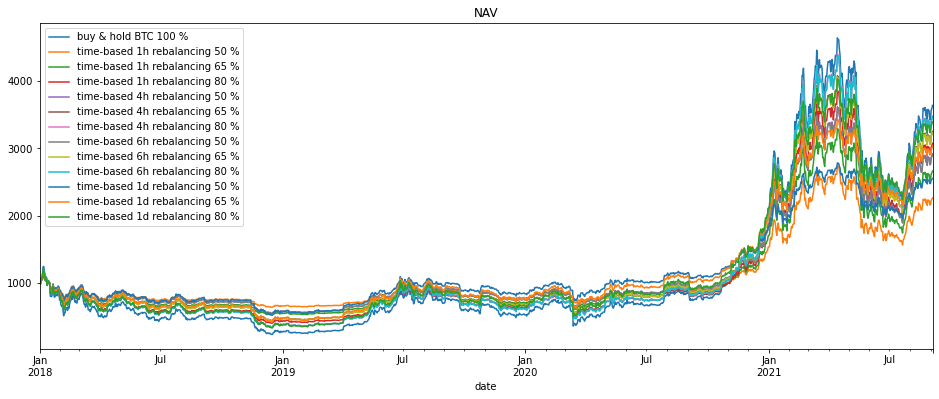

In [248]:
freqs = ('1h', '4h', '6h', '1d')
asset_ratios = (0.50, 0.65, 0.80)
# for asset_ratio in tqdm.tqdm(asset_ratios):
#     portfolio_price_df = buy_and_hold_by_ratio(price_df, asset_ratio=asset_ratio, capital=CAPITAL)
#     comparison_df[f'buy & hold BTC {int(asset_ratio*100)} %'] = portfolio_price_df['nav']

comparison_df[f'buy & hold BTC {100} %'] = buy_and_hold_by_ratio(price_df, asset_ratio=1.0, capital=CAPITAL)['nav']

params = list(itertools.product(freqs, asset_ratios))
for freq, asset_ratio in tqdm.tqdm(params):
    portfolio_df, portfolio_price_df = time_rebalance(price_df, frequency=freq, asset_ratio=asset_ratio, capital=CAPITAL)
    portfolio_name = f'time-based {freq} rebalancing {int(asset_ratio*100)} %'
    comparison_df[portfolio_name] = portfolio_price_df['nav']
    portfolios[portfolio_name] = portfolio_df
comparison_df = comparison_df.resample('1d').first()
comparison_df.plot(figsize=(16, 6), title='NAV')

Text(0.5, 0.98, 'NAV')

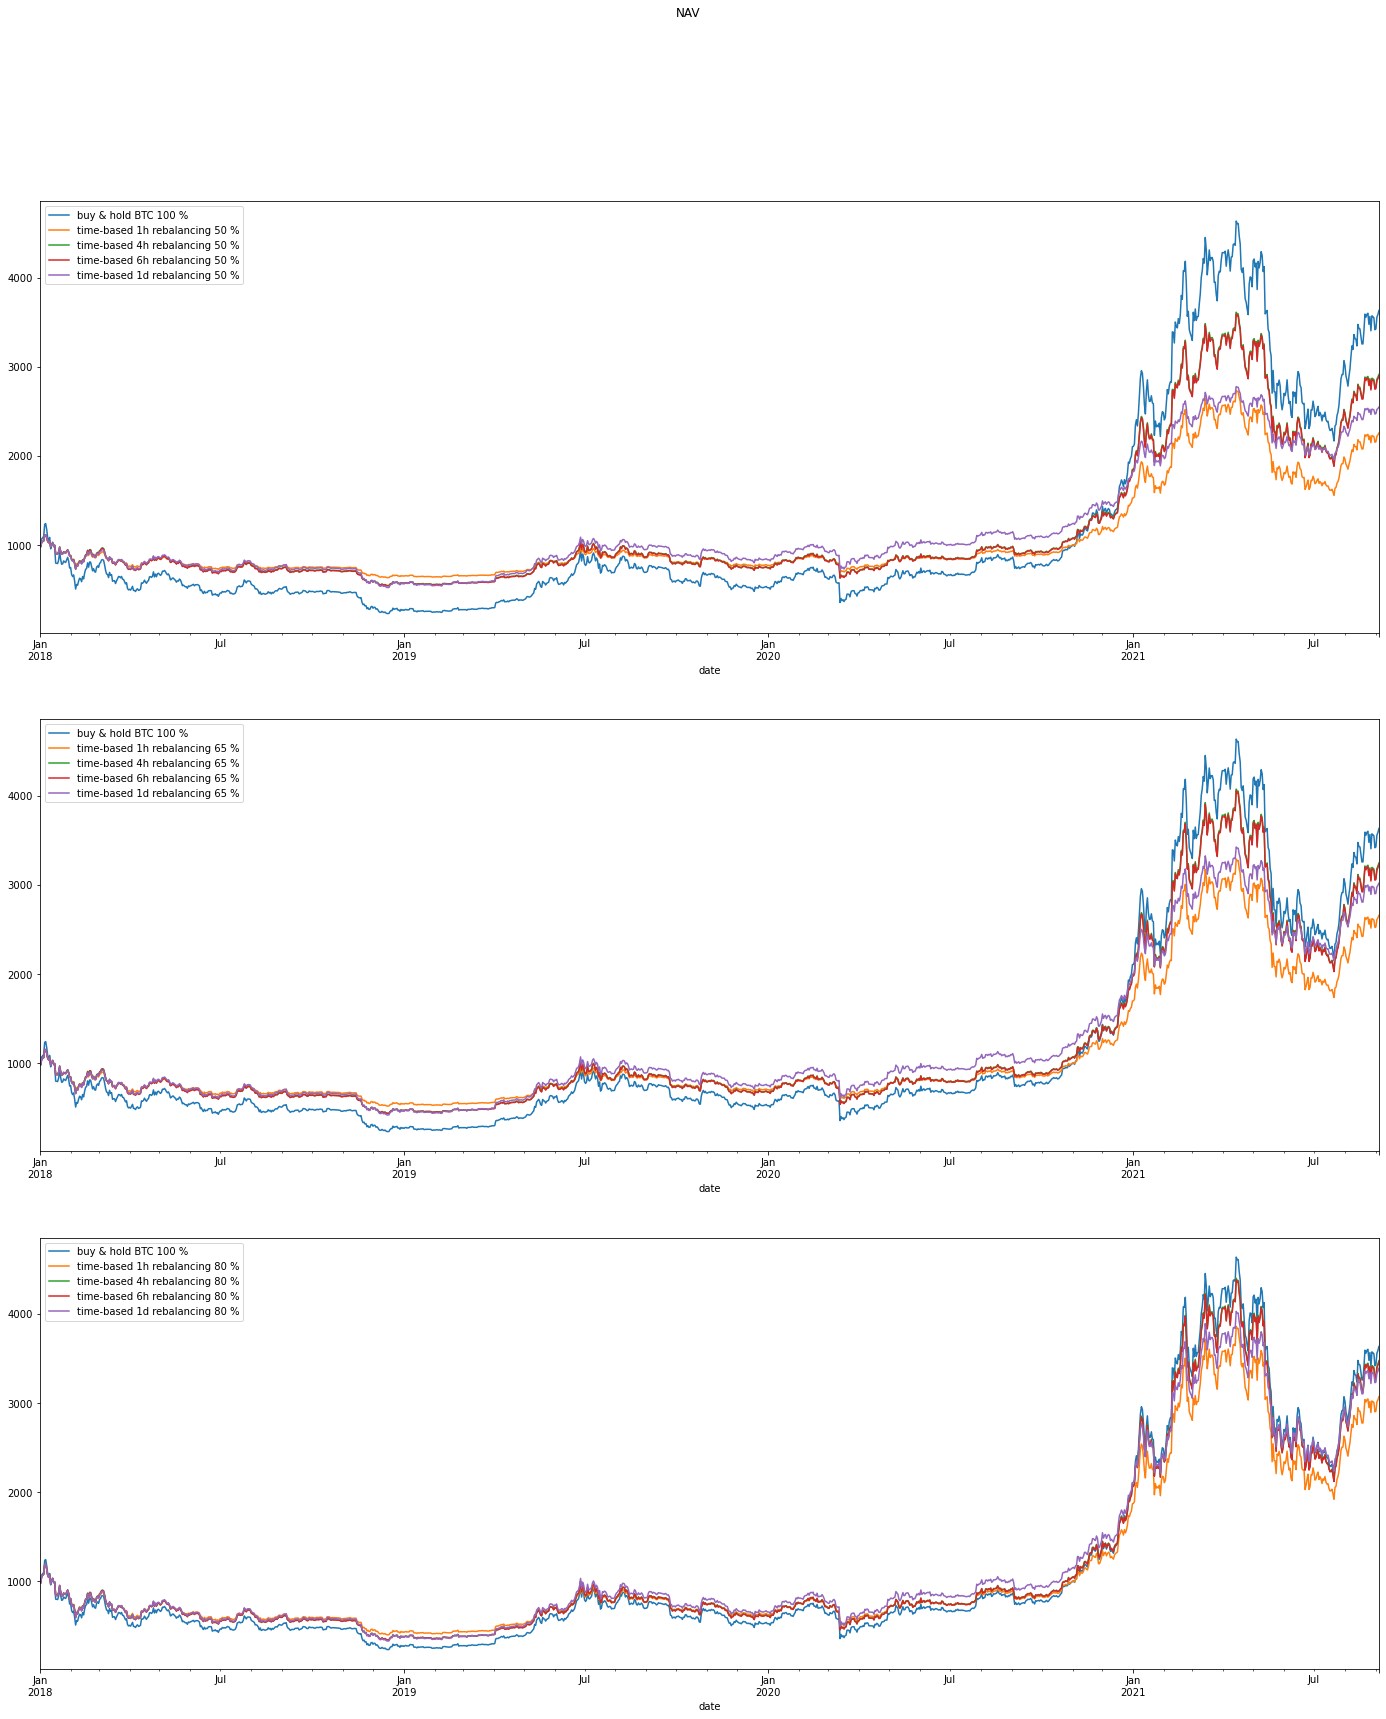

In [249]:
fig, axes = plt.subplots(nrows=len(asset_ratios), figsize=(24, 9*len(asset_ratios)))
for ax, asset_ratio in zip(axes, asset_ratios):
    comparison_df.filter(regex=f'.*BTC.*').plot(ax=ax)
    comparison_df.filter(regex=f'.*{int(asset_ratio*100)} %.*').plot(ax=ax)
fig.suptitle('NAV')


Text(0.5, 0.98, 'NAV')

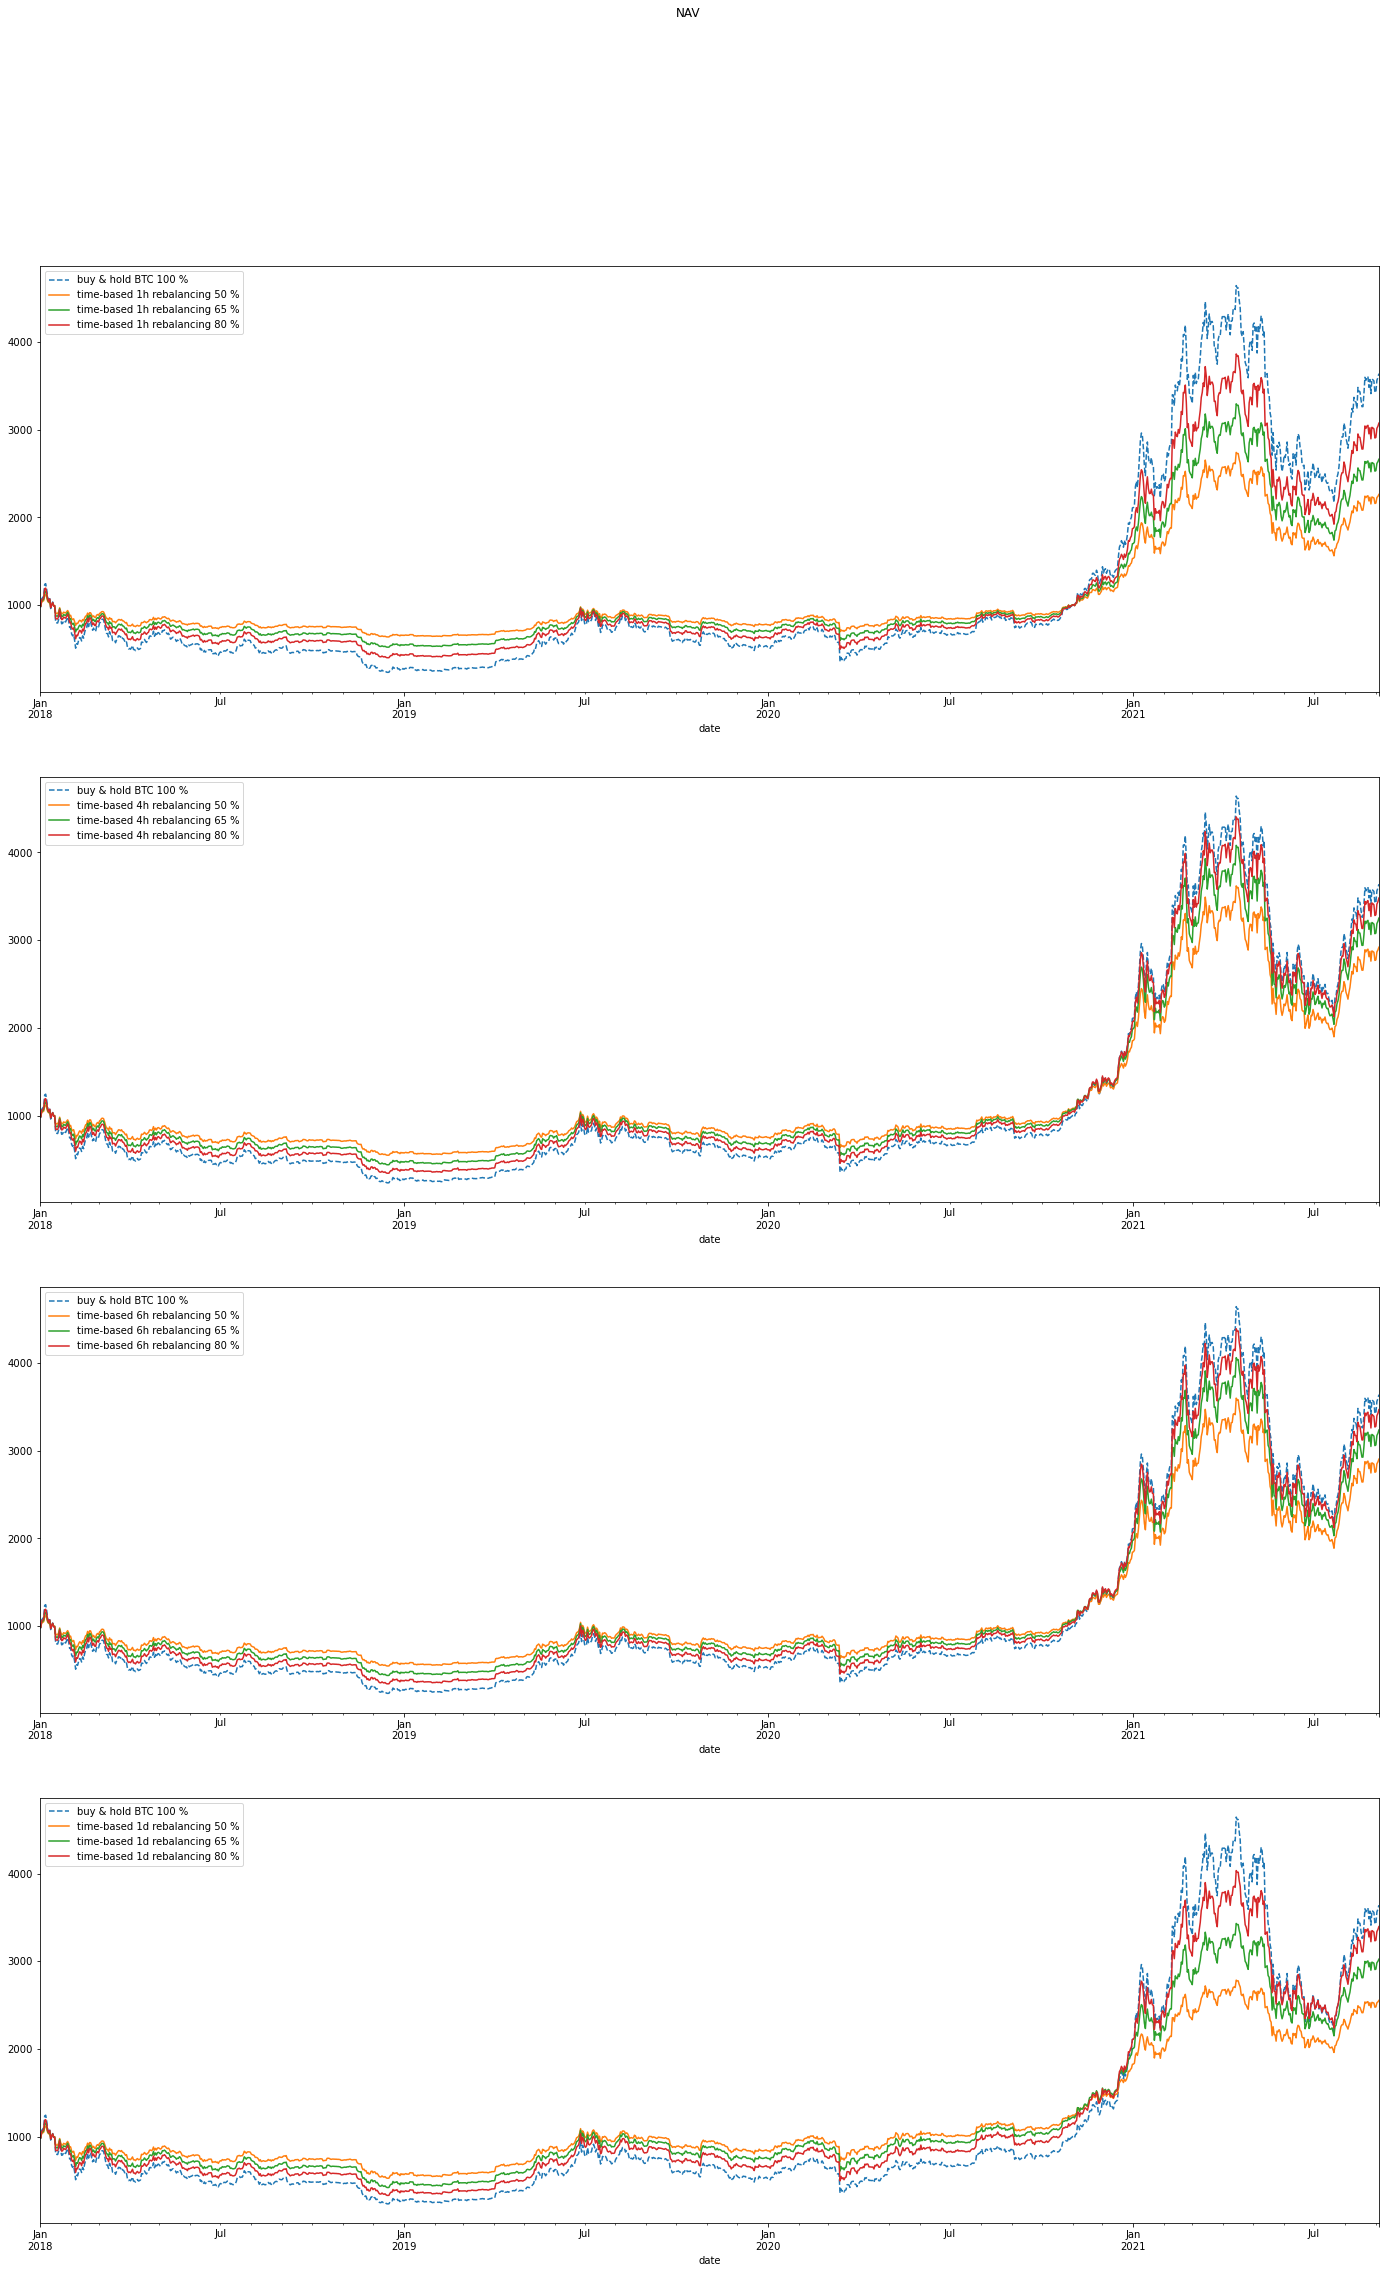

In [250]:
fig, axes = plt.subplots(nrows=len(freqs), figsize=(24, 9*len(freqs)))
for ax, freq in zip(axes, freqs):
    comparison_df.filter(regex=f'.*BTC.*').plot(ax=ax, linestyle='dashed')
    comparison_df.filter(regex=f'.*{freq}.*').plot(ax=ax)
fig.suptitle('NAV')

In [251]:
efficient_frontier_df = pd.DataFrame(data={
    'return': comparison_df.apply(expected_return, risk_free_rate=0.00),
    'volatility': comparison_df.apply(volatility),
    'sharpe': comparison_df.apply(sharpe_ratio, risk_free_rate=0.00),
})

In [252]:
efficient_frontier_df.style.background_gradient(axis=0,)


### Price-based Rebalancing

In [253]:
def generate_price_trigger(price_df, price_rebalance_ratio):
    init_price = price_df['close'].iloc[0]

    trigger_data = []
    current_position_price = init_price
    for dt, price in zip(price_df.index.values, price_df['close'].values):

        while True:
            upper_next_position_price = current_position_price * (1 + price_rebalance_ratio)
            lower_next_position_price = current_position_price * (1 - price_rebalance_ratio)

            if price > upper_next_position_price:
                current_position_price = upper_next_position_price
            elif price < lower_next_position_price:
                current_position_price = lower_next_position_price
            else:
                break

            trigger_data.append({
                'date': dt,
                'price': current_position_price
            })

    trigger_df = pd.DataFrame(trigger_data)
    return trigger_df

price_rebalance_ratio = 0.1
trigger_df = generate_price_trigger(price_df, price_rebalance_ratio)
trigger_df

date         price
0   2018-01-02 19:19:00  15078.712000
1   2018-01-05 17:24:00  16586.583200
2   2018-01-08 09:30:00  14927.924880
3   2018-01-08 14:49:00  13435.132392
4   2018-01-08 16:48:00  14778.645631
..                  ...           ...
248 2021-07-21 16:36:00  32257.457492
249 2021-07-26 00:12:00  35483.203241
250 2021-07-26 01:01:00  39031.523566
251 2021-08-06 16:10:00  42934.675922
252 2021-08-13 20:06:00  47228.143514

[253 rows x 2 columns]

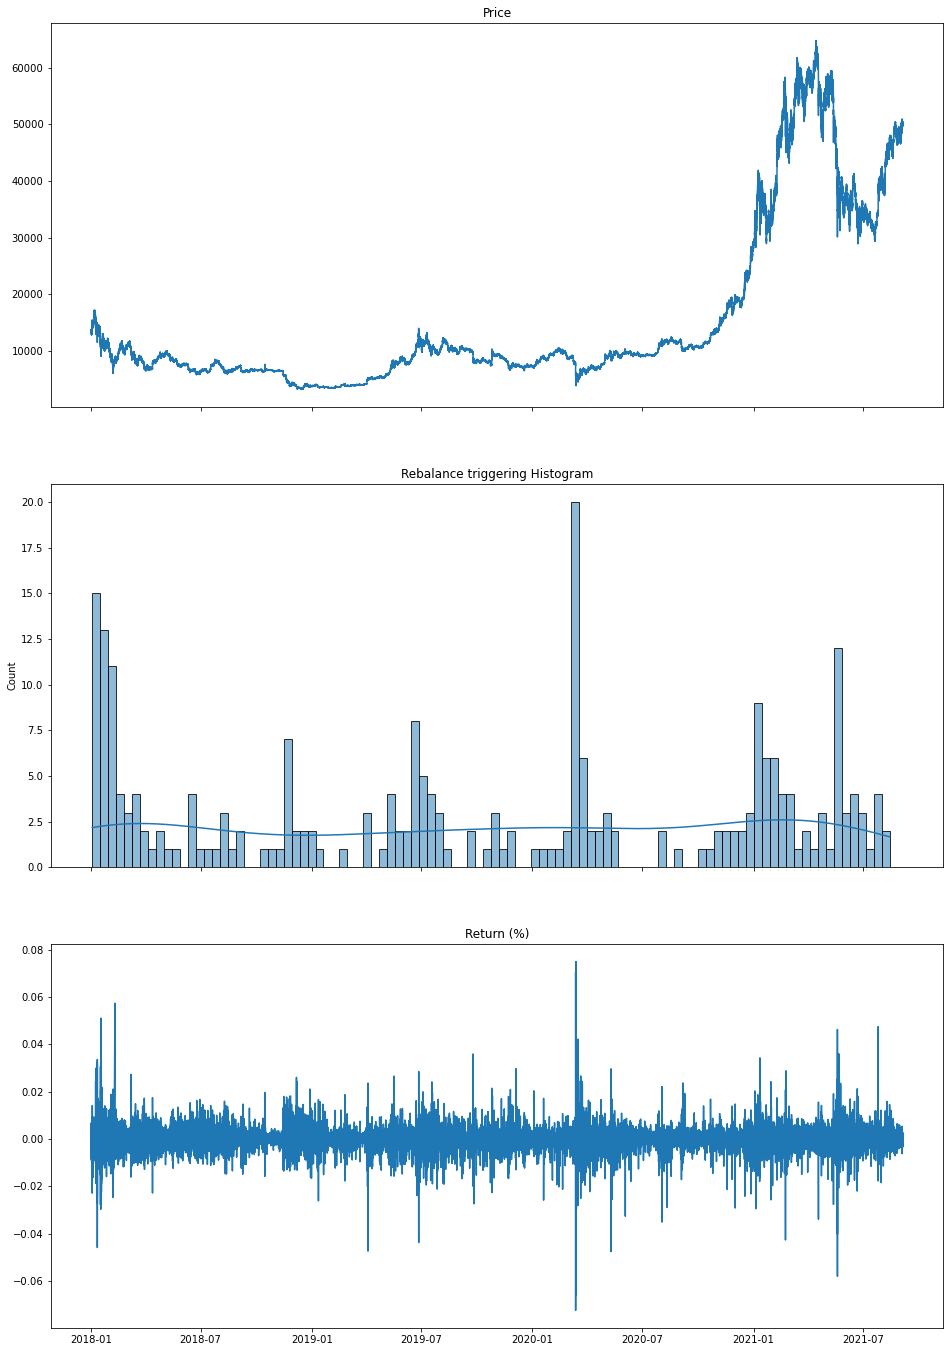

In [254]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(16, 24))

ax1.set_title('Price')
ax1.plot(price_df.index, price_df['close'])
ax2.set_title('Rebalance triggering Histogram')
sns.histplot(trigger_df, x='date', bins=100, kde=True, ax=ax2)
ax3.set_title('Return (%)')
ax3.plot(price_df.index, price_df['close'].pct_change())

In [255]:
def price_rebalance(price_df, price_rebalance_ratio, asset_ratio, capital, fix_asset=False):
    trigger_df = generate_price_trigger(price_df, price_rebalance_ratio)
    
    if fix_asset:
        return simulate_fixed_asset_rebalancing(price_df, trigger_df, asset_ratio, capital)
    else:
        return simulate_rebalancing(price_df, trigger_df, asset_ratio, capital)


In [256]:
portfolio_df, portfolio_price_df = price_rebalance(price_df, price_rebalance_ratio=0.2, asset_ratio=0.70, capital=CAPITAL)

In [257]:
portfolio_df

nav  asset_value  asset_amount        cash  \
date                                                                      
2018-01-01 00:00:00  1000.000000   700.000000      0.051065  300.000000   
2018-01-05 16:27:00  1140.000000   840.000000      0.051065  300.000000   
2018-01-08 15:05:00   980.400000   638.400000      0.048512  342.000000   
2018-01-16 21:02:00   843.144000   549.024000      0.052151  294.120000   
2018-01-20 05:38:00   961.184160   708.240960      0.056062  252.943200   
...                          ...          ...           ...         ...   
2021-06-08 15:21:00  2380.395604  1550.025044      0.049717  830.370559   
2021-06-09 23:29:00  2713.650988  1999.532307      0.053446  714.118681   
2021-06-22 12:25:00  2333.739850  1519.644553      0.050774  814.095296   
2021-06-29 12:46:00  2660.463429  1960.341474      0.054582  700.121955   
2021-08-06 17:44:00  3032.928309  2234.789280      0.051853  798.139029   

                            price  diff_asset_value action  re_asset_value  \
date                                                                         
2018-01-01 00:00:00           NaN               NaN    NaN             NaN   
2018-01-05 16:27:00  16449.504000        -42.000000   Sell      798.000000   
2018-01-08 15:05:00  13159.603200         47.880000    Buy      686.280000   
2018-01-16 21:02:00  10527.682560         41.176800    Buy      590.200800   
2018-01-20 05:38:00  12633.219072        -35.412048   Sell      672.828912   
...                           ...               ...    ...             ...   
2021-06-08 15:21:00  31176.763310        116.251878    Buy     1666.276923   
2021-06-09 23:29:00  37412.115972        -99.976615   Sell     1899.555692   
2021-06-22 12:25:00  29929.692778        113.973342    Buy     1633.617895   
2021-06-29 12:46:00  35915.631333        -98.017074   Sell     1862.324400   
2021-08-06 17:44:00  43098.757600       -111.739464   Sell     2123.049816   

                     re_asset_amount     re_cash       re_nav  
date                                                           
2018-01-01 00:00:00              NaN         NaN          NaN  
2018-01-05 16:27:00         0.048512  342.000000  1140.000000  
2018-01-08 15:05:00         0.052151  294.120000   980.400000  
2018-01-16 21:02:00         0.056062  252.943200   843.144000  
2018-01-20 05:38:00         0.053259  288.355248   961.184160  
...                              ...         ...          ...  
2021-06-08 15:21:00         0.053446  714.118681  2380.395604  
2021-06-09 23:29:00         0.050774  814.095296  2713.650988  
2021-06-22 12:25:00         0.054582  700.121955  2333.739850  
2021-06-29 12:46:00         0.051853  798.139029  2660.463429  
2021-08-06 17:44:00         0.049260  909.878493  3032.928309  

[74 rows x 11 columns]

100%|██████████| 27/27 [01:29<00:00,  3.31s/it]


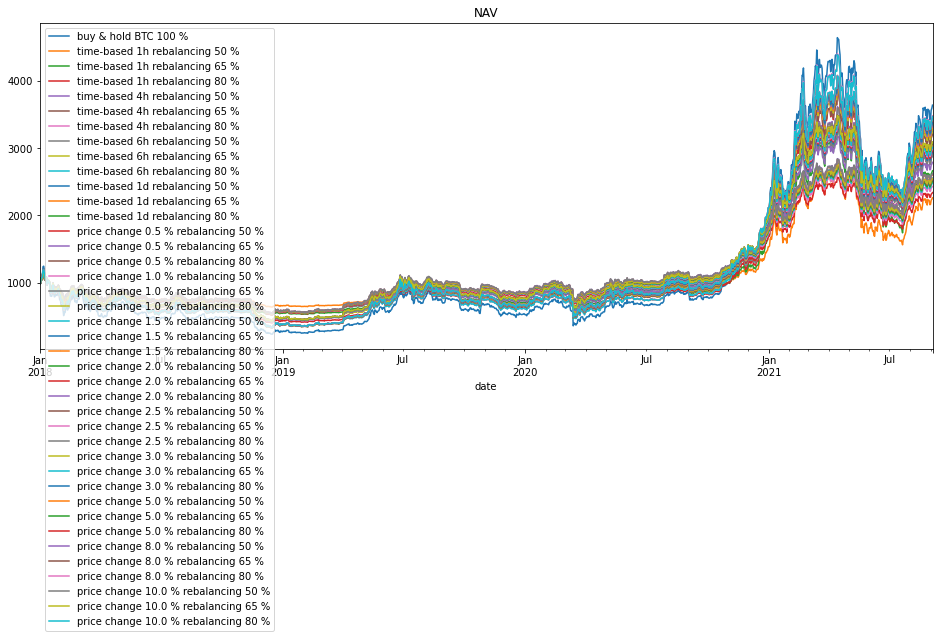

In [258]:

price_change_percentages = (0.50, 1.00, 1.50, 2.00, 2.50, 3.00, 5.00, 8.00, 10.00) 
asset_ratios = (0.50, 0.65, 0.80)

# for asset_ratio in tqdm.tqdm(asset_ratios):
#     portfolio_price_df = buy_and_hold_by_ratio(price_df, asset_ratio=asset_ratio, capital=CAPITAL)
#     comparison_df[f'buy & hold BTC {int(asset_ratio*100)} %'] = portfolio_price_df['nav']

params = list(itertools.product(price_change_percentages, asset_ratios))
for percent, asset_ratio in tqdm.tqdm(params):
    portfolio_df, portfolio_price_df = price_rebalance(price_df,
                                                       price_rebalance_ratio=percent/100,
                                                       asset_ratio=asset_ratio,
                                                       capital=CAPITAL)
    portfolio_name = f'price change {percent} % rebalancing {int(asset_ratio*100)} %'
    portfolios[portfolio_name] = portfolio_df
    comparison_df[portfolio_name] = portfolio_price_df['nav']
    
comparison_df = comparison_df.resample('1d').first()
comparison_df.plot(figsize=(16, 6), title='NAV')

Text(0.5, 0.98, 'NAV')

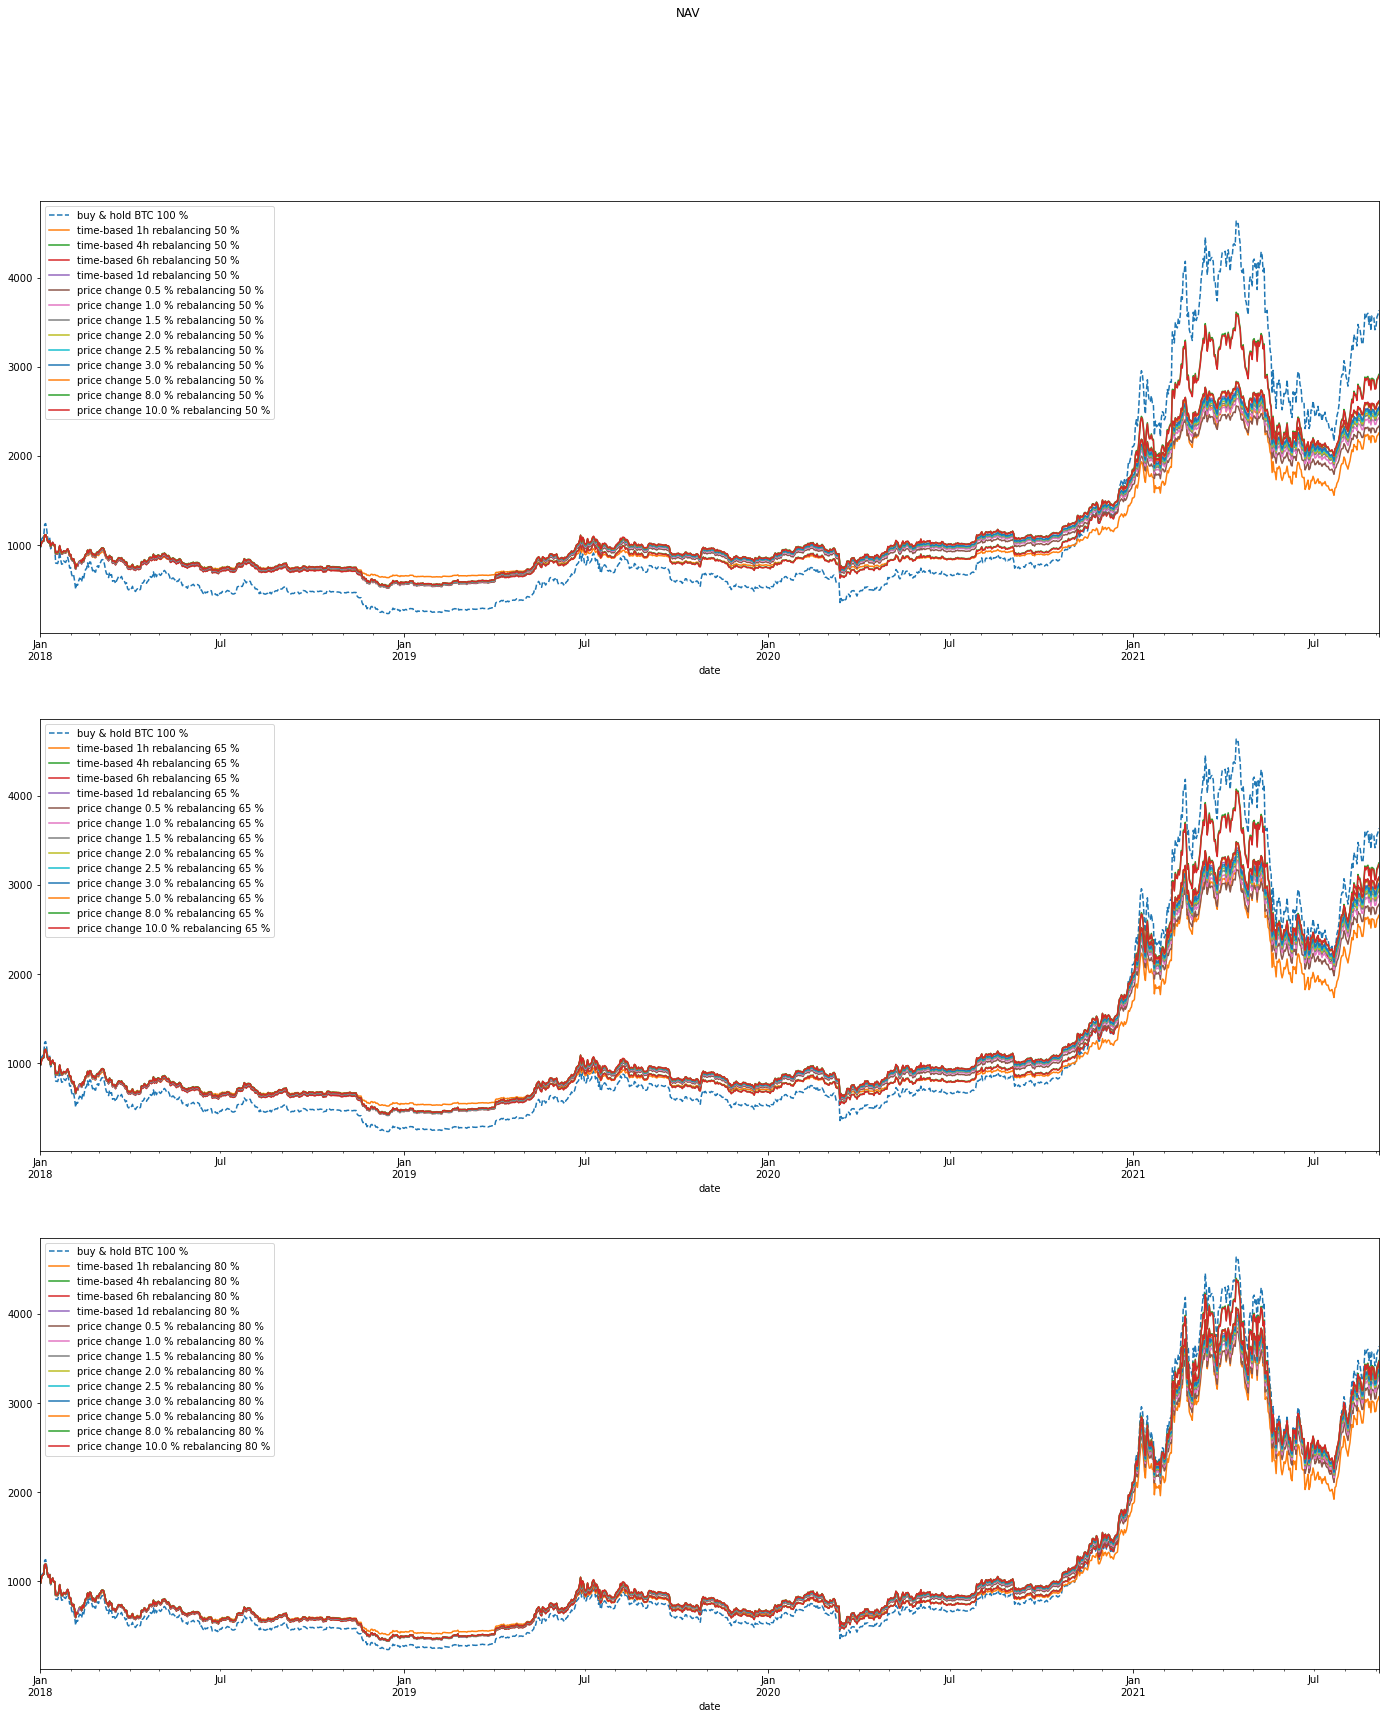

In [259]:
fig, axes = plt.subplots(nrows=len(asset_ratios), figsize=(24, 9*len(asset_ratios)))
for ax, asset_ratio in zip(axes, asset_ratios):
    comparison_df.filter(regex=f'.*BTC.*').plot(ax=ax, linestyle='dashed')
    comparison_df.filter(regex=f'.*rebalancing {int(asset_ratio*100)} %.*').plot(ax=ax)
fig.suptitle('NAV')


Text(0.5, 0.98, 'NAV')

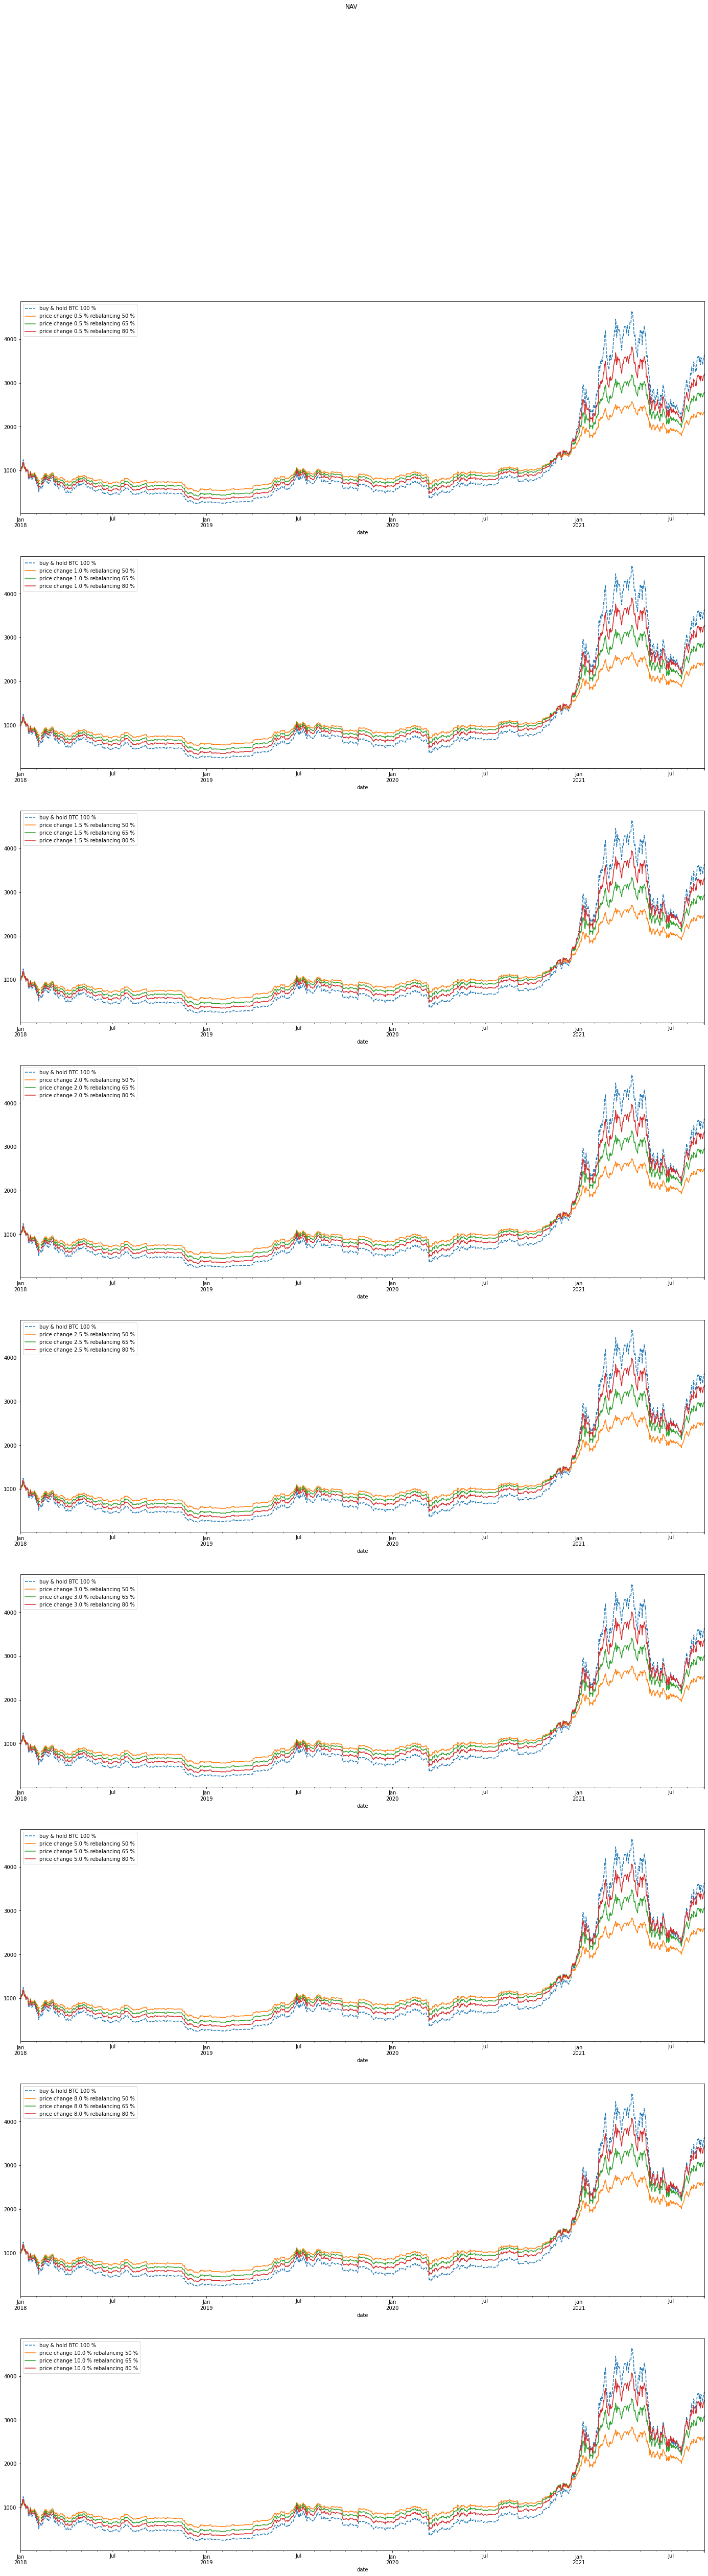

In [260]:
fig, axes = plt.subplots(nrows=len(price_change_percentages), figsize=(24, 9*len(price_change_percentages)))
for ax, percent in zip(axes, price_change_percentages):
    comparison_df.filter(regex=f'.*BTC.*').plot(ax=ax, linestyle='dashed')
    comparison_df.filter(regex=f'.*price change {percent:.1f} %.*').plot(ax=ax)
    
fig.suptitle('NAV')

In [261]:
# rebalance_comparison_df = comparison_df.filter(regex='.*rebalancing.*')
rebalance_comparison_df = comparison_df.resample('1d').first()
efficient_frontier_df = pd.DataFrame(data={
    'number of order': pd.Series(portfolios).map(len),
    'return': rebalance_comparison_df.apply(expected_return, risk_free_rate=0.00),
    'volatility': rebalance_comparison_df.apply(volatility),
    'sharpe': rebalance_comparison_df.apply(sharpe_ratio, risk_free_rate=0.00),
    'max_drawdown': rebalance_comparison_df.apply(max_drawdown),
}).fillna({'number of order': 0})
efficient_frontier_df.style.background_gradient(axis=0,)


### Price-based + Fixed asset Rebalancing

100%|██████████| 27/27 [01:28<00:00,  3.27s/it]


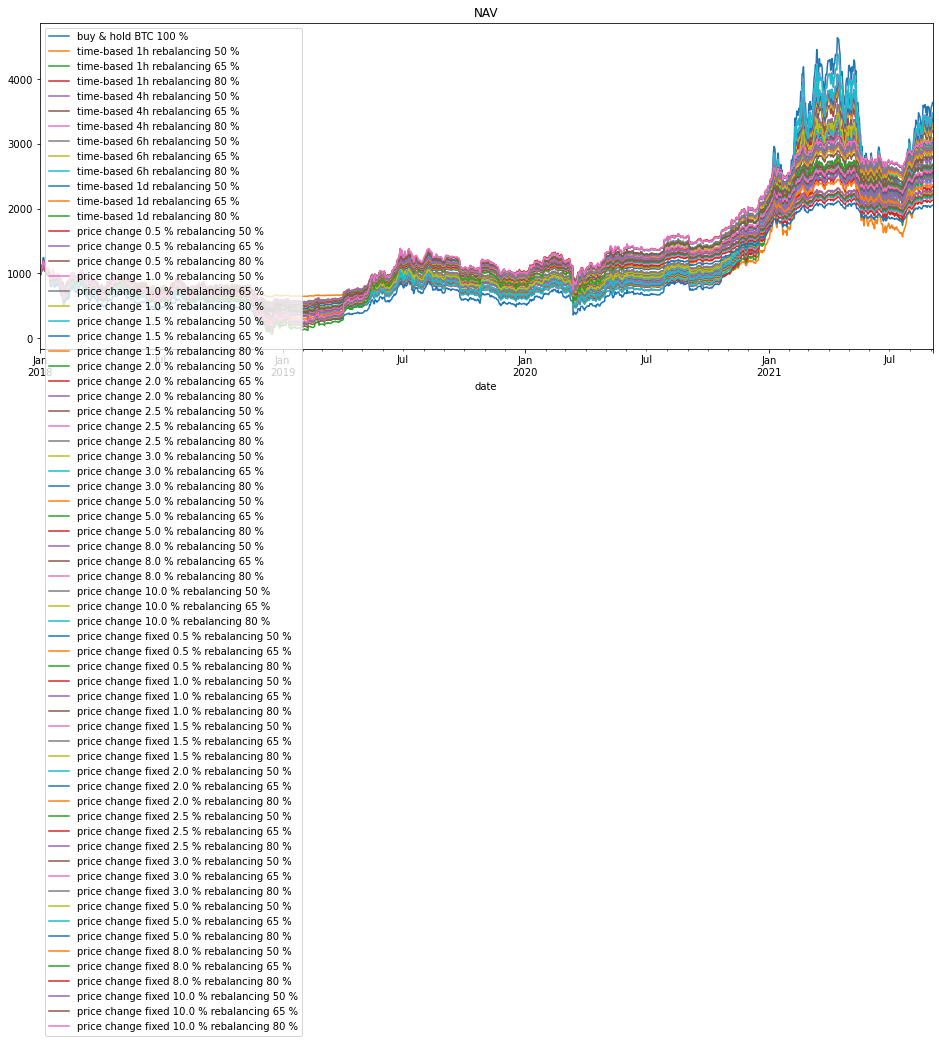

In [262]:
price_change_percentages = (0.50, 1.00, 1.50, 2.00, 2.50, 3.00, 5.00, 8.00, 10.00) 
asset_ratios = (0.50, 0.65, 0.80)

params = list(itertools.product(price_change_percentages, asset_ratios))
for percent, asset_ratio in tqdm.tqdm(params):
    portfolio_df, portfolio_price_df = price_rebalance(price_df,
                                                       price_rebalance_ratio=percent/100,
                                                       asset_ratio=asset_ratio,
                                                       capital=CAPITAL,
                                                       fix_asset=True
                                                      )
    portfolio_name = f'price change fixed {percent} % rebalancing {int(asset_ratio*100)} %'
    portfolios[portfolio_name] = portfolio_df
    comparison_df[portfolio_name] = portfolio_price_df['nav']
    
comparison_df = comparison_df.resample('1d').first()

comparison_df.plot(figsize=(16, 6), title='NAV')

Text(0.5, 0.98, 'NAV')

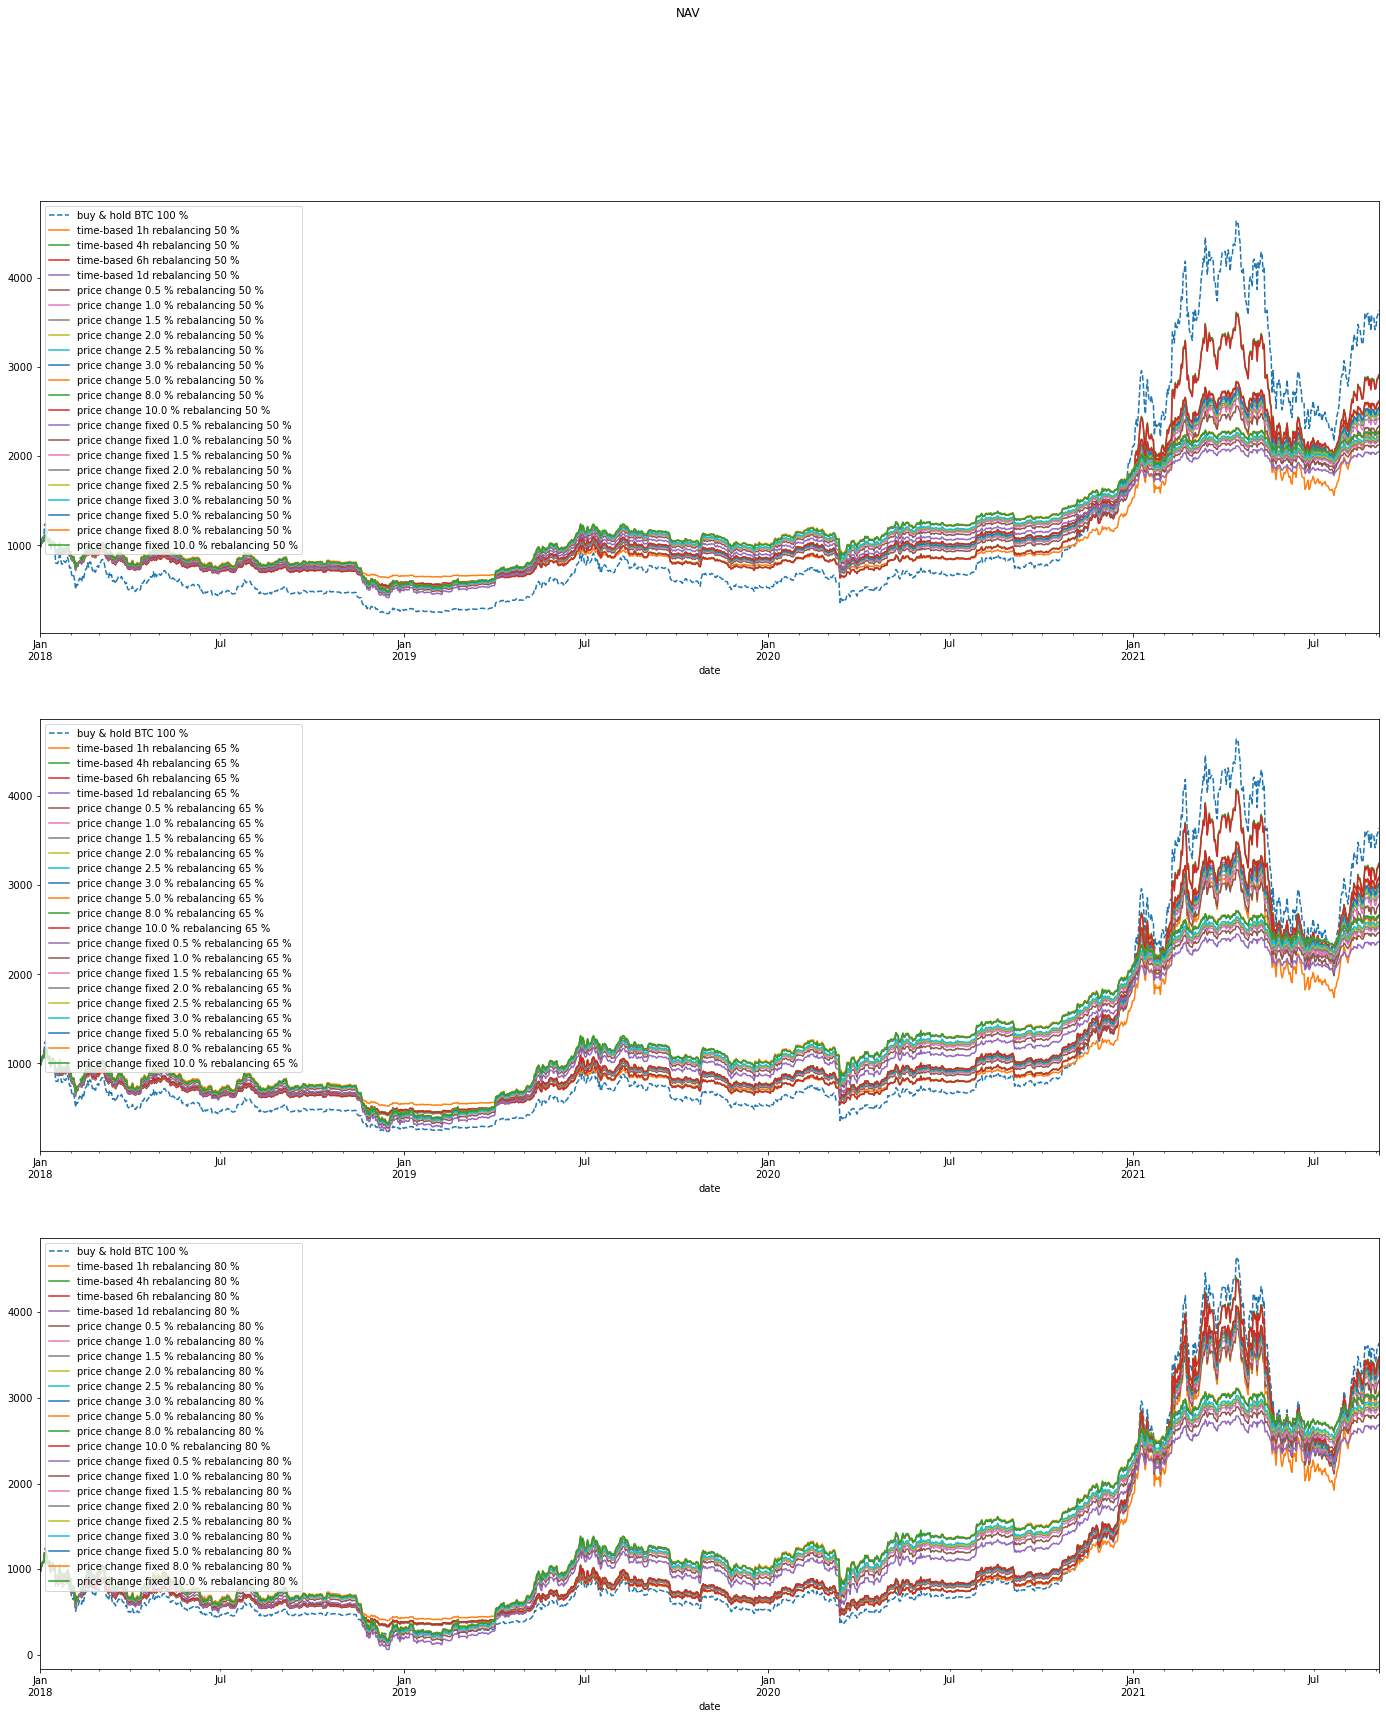

In [263]:
fig, axes = plt.subplots(nrows=len(asset_ratios), figsize=(24, 9*len(asset_ratios)))
for ax, asset_ratio in zip(axes, asset_ratios):
    comparison_df.filter(regex=f'.*BTC.*').plot(ax=ax, linestyle='dashed')
    comparison_df.filter(regex=f'.*rebalancing {int(asset_ratio*100)} %.*').plot(ax=ax)
fig.suptitle('NAV')


Text(0.5, 0.98, 'NAV')

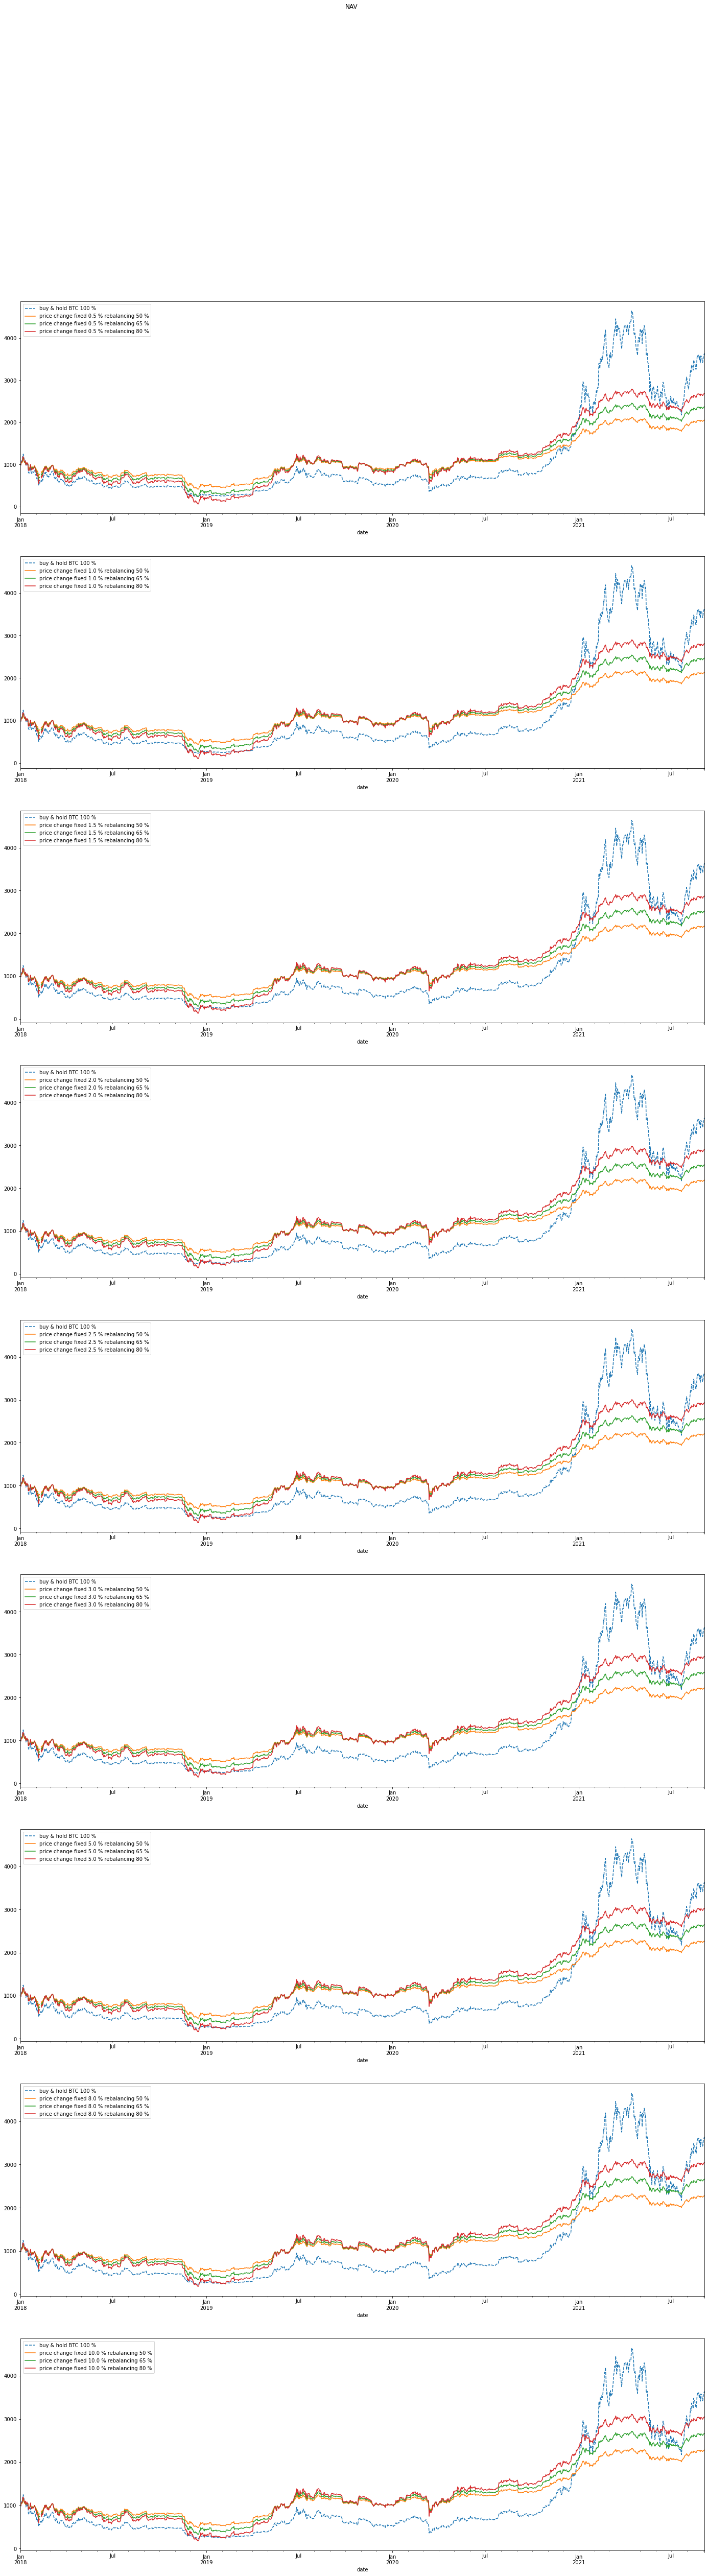

In [264]:
fig, axes = plt.subplots(nrows=len(price_change_percentages), figsize=(24, 9*len(price_change_percentages)))
for ax, percent in zip(axes, price_change_percentages):
    comparison_df.filter(regex=f'.*BTC.*').plot(ax=ax, linestyle='dashed')
    comparison_df.filter(regex=f'.*price change fixed {percent:.1f} %.*').plot(ax=ax)
    
fig.suptitle('NAV')

In [266]:
# rebalance_comparison_df = comparison_df.filter(regex='.*rebalancing.*')
rebalance_comparison_df = comparison_df.resample('1d').first()
efficient_frontier_df = pd.DataFrame(data={
    'number of order': pd.Series(portfolios).map(len),
    'return': rebalance_comparison_df.apply(expected_return, risk_free_rate=0.00),
    'volatility': rebalance_comparison_df.apply(volatility),
    'sharpe': rebalance_comparison_df.apply(sharpe_ratio, risk_free_rate=0.00),
    'max_drawdown': rebalance_comparison_df.apply(max_drawdown),
}).fillna({'number of order': 0})
efficient_frontier_df.style.background_gradient(axis=0,)


# Export report


In [271]:
output_dir = Path('output')


In [272]:
efficient_frontier_df.to_excel(output_dir / 'summary.xlsx')

In [273]:
for name, portfolio_df in portfolios.items():
    portfolio_df.to_excel(output_dir / f'{name}_transaction.xlsx')
for name, portfolio_price_df in comparison_df.items():
    portfolio_price_df.to_excel(output_dir / f'{name}_price.xlsx')
